In [35]:
import numpy as np
import matplotlib.pyplot as plt

from fastprogress import progress_bar

from scipy.integrate import quad
from scipy.optimize import root, bisect

import arviz as az
import arviz.labels as azl

# Some functions

In [2]:
def logp(x, c, gamma):
    """Evaluates the log of the density function.
    """

    result = np.log(2 * gamma * (c**2 + gamma**2))
    result -= np.log(np.pi * (gamma**2 + (x - c)**2))
    result -= np.log((gamma**2 + (x + c)**2))

    return result


def cdf(x, c, gamma):
    """Evaluates the CDF.
    """

    fac = ( (c**2) + (gamma**2) )/( np.pi*(4*(c**3) + 4*c*(gamma**2)  )  )

    # p1 = 2*c*np.pi
    # p2 = -2*c*np.arctan( (c-x)/gamma )
    # p3 = 2*c*np.arctan( (c+x)/gamma )
    # p4 = -gamma*np.log( (gamma**2) + ((c-x)**2)  )
    # p5 = gamma*np.log( (gamma**2) + ((c+x)**2)  )

    p1 = 2*c*np.pi
    p2 = -2*c*np.arctan2( (c-x), gamma )
    p3 = 2*c*np.arctan2( (c+x),gamma )
    p4 = -gamma*np.log( (gamma**2) + ((c-x)**2)  )
    p5 = gamma*np.log( (gamma**2) + ((c+x)**2)  )

    return fac*(p1+p2+p3+p4+p5)


# veclogp = np.vector

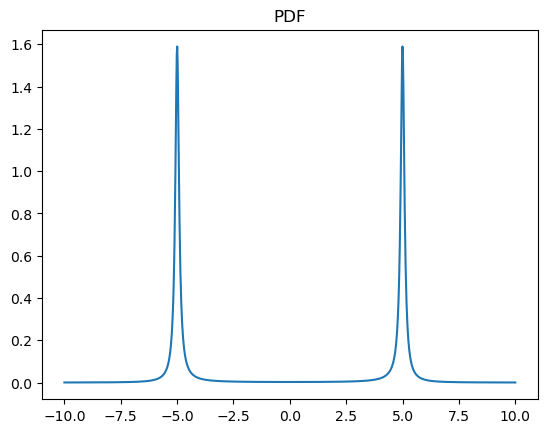

In [3]:
c = 5
gamma = 0.1
dom = np.linspace(-10, 10, 1000)
rang = logp(dom, c, gamma)

plt.plot(dom, np.exp(rang))
plt.title("PDF")
plt.show()

In [4]:
# Check that it integrate to 1!
quad(lambda x: np.exp(logp(x, c, gamma)), -np.inf, np.inf)

(0.9999999999999987, 1.4158776334840193e-08)

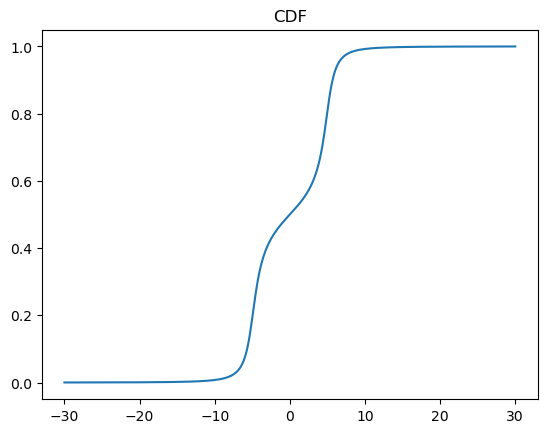

In [5]:
# Plot CDG

c = 5
gamma = 1.0
dom = np.linspace(-30, 30, 1000)
rang = cdf(dom, c, gamma)

plt.plot(dom, rang)
plt.title("CDF")
plt.show()

# Sampling from the density

In [6]:
def inv_cdf(u, c, gamma):
    """Evaluates the inverse CDF.
    """

    g = lambda z: cdf(z, c, gamma) - u
    root_res = root(g, x0=0)
    #root_res = bisect(g, -1000*c, 1000*c, maxiter=10000)
    assert root_res.status == 1, "root-finding did not converge!"

    return root_res.x[0]

In [7]:
inv_cdf(0.3, 5.0, 1.0)

-4.29548914520808

In [40]:
# Parameters
c = 5.0
gamma = 1.0
n_samples = int(1e5)

# Draw samples
u_samples = []
x_samples = []
for i in progress_bar(range(n_samples)):
    
    # Draw random uniform
    u = np.random.uniform()
    u_samples.append(u)

    # Apply T
    x = inv_cdf(u, c, gamma)
    x_samples.append(x)

u_samples = np.asarray(u_samples)
x_samples = np.asarray(x_samples)

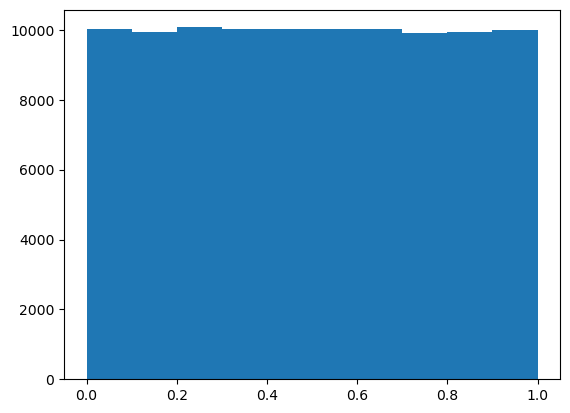

In [41]:
plt.hist(u_samples)
plt.show()

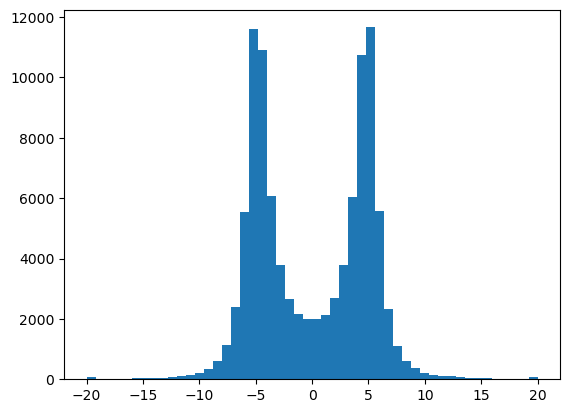

In [42]:
plt.hist(np.clip(x_samples, a_min=-20, a_max=20), bins=50)
plt.show()

In [43]:
data_dct = {
    "u": u_samples.reshape((1, n_samples, 1)),
    "x": np.clip(x_samples.reshape((1, n_samples, 1)), a_min=-30, a_max=30),
}
data = az.convert_to_inference_data(data_dct)

In [44]:
# data = az.convert_to_inference_data( np.vstack([u_samples, x_samples]).reshape((1, n_samples, 1, 1)) )

/Users/jonathanlindbloom/opt/miniconda3/envs/jlinops/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


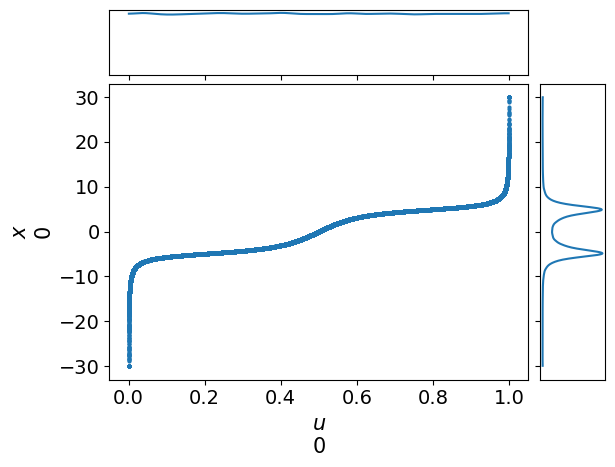

In [49]:
labeller = azl.MapLabeller(var_name_map={"u": r"$u$", "x":r"$x$"})

az.plot_pair(data, marginals=True, var_names=["u", "x"], labeller=labeller)
plt.show()